In [1]:
import numpy as np
import pandas as pd
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, clear_output

from data_parser import parse
from data_modification import normalize_patient
#from VCG_plot_widget import plot_vcg_data

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
#plt.rcParams.update({'font.size': 16})

# VCG Vizualization To Do:
### Basic plotting function
* ~~Add planar projections~~
* ~~Add labels to XYZ graphs and planar projections~~
* ~~Add information about the patient id~~
* ~~Display Simulation parameters for vcg_model~~

### Advanced plotting function
* ~~Separate model vcg compare and clinical~~
* ~~Add clinical to figure~~
* ~~Add normalization option~~
* ~~fix parameter display strings~~
* ~~Disable selections not available during clinical~~
* ~~Add legend for compare_select~~
* ~~Visual display for pacing locaiton~~
* ~~Implement pacing location slider~~
* ~~Handle missing VCG and missing eval_values~~
* ~~Display simulation number~~
* make sim slider and pacing node slider update for each patient
* Add option to input sim number manually
* fix axes across patient when set to norm
* Try to add cylindrical border
* make GUI a class and move out of script
* Add error trapping for input data
* more gracefully handle time input
* Add arrows to 2D projections

### database functionality
* ~~Filter pacing by location~~
* ~~Include proper simulation number with VCG data~~
* ~~Add node form to database for each patient~~
* Add node grid to database for each patient
* Check VCG cont/kors rotation

### Questions
* Why use change['new'] instead of widget.value on observe?

# Load Data

In [3]:
#Parse data
data_path = '/Users/kevin/Continuity/Simulations/MachineLearningPaper/LBBB_LVdyssync'
patients = [
        normalize_patient(
            parse(initial_path=data_path, patient_number=patient_no) 
        )
        #for patient_no in [0]
        for patient_no in range(0,8)
]

# Plotting Function

In [26]:
def plot_vcg_data(patient,param,pacing_node,clinical,norm_select,compare_select):
    """Generate a plot to display .
    """ 
    # NEED TO ADD QUALITY CONTROL FOR INPUT
    if norm_select:
        norm = '_norm'
    else:
        norm = ''
    if clinical:
        data = patient['vcg_real'+norm]
        fig.suptitle(patient['pt_id'] + ' Clinical VCG', fontsize=18,fontweight='bold')
    else:
        sim = patient['eval_values'][patient['eval_values']['pacing_nodes']==pacing_node].index[0]+param-1
        data = patient['vcg_model'+norm][sim]
        if not isinstance(data,pd.DataFrame):
            data = pd.DataFrame(0,index=np.arange(3),columns=['VCGx','VCGy','VCGz'])
        G = patient['eval_values']['cond'][sim]
        RV = patient['eval_values']['R'][sim]
        LV = patient['eval_values']['L'][sim]
        fig.suptitle(patient['pt_id'] + ' Simulation %i'%(sim+1), fontsize=18,fontweight='bold')
        p_txt.set_text('Pacing node\n%i'%pacing_node)
        g_txt.set_text('Conductivity\n%.5f'%G)
        rv_txt.set_text('RV endo ratio\n%.1f'%RV)
        lv_txt.set_text('LV endo ratio\n%.1f'%LV)

    ### Plot XYZ time series
    #assume 1 ms per sample for now
    t = np.arange(len(data['VCGx']))

    ax1.clear()
    ax1.plot(t,data['VCGx'],'k-')
    ax1.set_title('X',x=0,y=0.8, fontsize=16)
    ax1.axis('off')
    
    ax2.clear()
    ax2.plot(t,data['VCGy'],'k-')
    ax2.set_title('Y',x=0,y=0.8, fontsize=16)
    ax2.axis('off')
    
    ax3.clear()
    ax3.plot(t,data['VCGz'],'k-')
    ax3.set_title('Z',x=0,y=0.8, fontsize=16)
    ax3.axis('off')
    
    ax4.clear()
    ax4.plot(t,np.linalg.norm(data,axis=1),'k-',label = 'Simulated VCG')
    ax4.set_title('Mag.',x=-0.05,y=0.9,fontsize=16)
    ax4.spines['right'].set_color('none')
    ax4.spines['top'].set_color('none')
    
    ax5.clear()
    ax5.plot(data['VCGx'],data['VCGz']*-1,'k-')
    ax5.set_title('Transverse', fontsize=16)
    ax5.axis('off')
    ax5.axis('equal')
    
    ax6.clear()
    ax6.plot(data['VCGx'],data['VCGy']*-1,'k-')
    ax6.set_title('Frontal', fontsize=16)
    ax6.axis('off')
    ax6.axis('equal')
    
    ax7.clear()
    ax7.plot(data['VCGz']*-1,data['VCGy']*-1,'k-')
    ax7.set_title('Left Sagittal', fontsize=16)
    ax7.axis('off')
    ax7.axis('equal')
    
    ax8.clear()
    ax8.axis('off')
    if not clinical:
        ax8.scatter(patient['eval_values']['z'],patient['eval_values']['x']*-1,facecolors='none', edgecolors='k')
        ax8.scatter(patient['eval_values']['z'][sim],patient['eval_values']['x'][sim]*-1,c='k')
        ax8.set_title('RVFW')
    
    if compare_select:
        clin_data = patient['vcg_real_norm']
        clin_t = np.arange(len(clin_data['VCGx']))
        ax1.plot(clin_t,clin_data['VCGx'],'k--')
        ax2.plot(clin_t,clin_data['VCGy'],'k--')
        ax3.plot(clin_t,clin_data['VCGz'],'k--')
        ax4.plot(clin_t,np.linalg.norm(clin_data,axis=1),'k--',label ='Clinical VCG')
        ax5.plot(clin_data['VCGx'],clin_data['VCGz']*-1,'k--')
        ax6.plot(clin_data['VCGx'],clin_data['VCGy']*-1,'k--')
        ax7.plot(clin_data['VCGz']*-1,clin_data['VCGy']*-1,'k--')
        #ax4.legend(prop={'size': 16},frameon=False,bbox_to_anchor=(0.6,0.6))
    
    with out:
        clear_output(wait=True)
        display(fig)

In [27]:
#build GUI
id_dict = {}
for x,patient in enumerate(patients):
    id_dict[patient['pt_id']] = x   
    
pt_select = widgets.Dropdown(
    options=id_dict,
    value=0,
    description='Patient ID:',
    disabled=False,
)

type_select = widgets.RadioButtons(
    #options=['Clinical VCG', 'Simulation VCG'],
    options={'Simulation VCG':False,'Clinical VCG':True},
     value=True,
    description='',
    disabled=False
)

pt_box = widgets.VBox()
pt_box.children = [pt_select,type_select]

norm_select = widgets.Checkbox(
    value=False,
    description='Normalize VCG',
    disabled=False
)
center = widgets.Checkbox(
    value=False,
    description='Center VCG',
    disabled=False
)
compare_select = widgets.Checkbox(
    value=False,
    description='Compare to clincical VCG',
    disabled=True
)
opts_box = widgets.VBox()
opts_box.children = [norm_select,center,compare_select]

sim = widgets.IntSlider(
    #Make max variable? patient['eval_values'][patient['eval_values']['pacing_nodes']==patients[0]['eval_values']['pacing_nodes'].unique()[0]]
    min=1, max=16, step=1, 
    value=1,
    description='Simulation:',
    disabled = True,
    continuous_update=False
)

pace_node = widgets.SelectionSlider(
    options= patients[0]['eval_values']['pacing_nodes'].unique(),
    value = patients[0]['eval_values']['pacing_nodes'].unique()[0],
    description = 'Pacing Node:',
    disabled = True,
    continuous_update=False
    )

words = ['Superior', 'Inferior', 'Anterior', 'Posterior']
items = [widgets.Button(description=w,disabled=True,button_style='info') for w in words]
high_box = widgets.HBox([widgets.Label('fix this space problem.....'),items[0],widgets.Label('')])
low_box = widgets.HBox([items[2],items[1],items[3]])
nav_box = widgets.VBox([high_box, low_box])

gui_box = widgets.VBox([widgets.HBox([pt_box,opts_box]),widgets.HBox([sim,pace_node]),nav_box])
out = widgets.Output()
all_box = widgets.VBox([out,gui_box])


In [28]:
#plt.ioff()
fig = plt.figure(figsize = (9,9))
ax1 = plt.subplot2grid((12,12), (0,0), colspan=7,rowspan=2)
ax2 = plt.subplot2grid((12,12), (2,0), colspan=7,rowspan=2)
ax3 = plt.subplot2grid((12,12), (4,0), colspan=7,rowspan=2)
ax4 = plt.subplot2grid((12,12), (6,0), colspan=7,rowspan=2)
ax5 = plt.subplot2grid((12,12), (0,8), colspan=4,rowspan=4)
ax6 = plt.subplot2grid((12,12), (4,8), colspan=4,rowspan=4)
ax7 = plt.subplot2grid((12,12), (8,8), colspan=4,rowspan=4)
ax8 = plt.subplot2grid((12,12), (9,2), colspan=4,rowspan=3)
#ax = [ax1,ax2,ax3,ax4,ax5,ax6,ax7]
p_txt = fig.text(0.2,0,'', fontsize = 16, ha='center')
g_txt = fig.text(0.4,0,'', fontsize = 16, ha='center')
rv_txt = fig.text(0.6,0,'',fontsize = 16, ha='center')
lv_txt = fig.text(0.8,0,'',fontsize = 16, ha='center')
plt.close(fig)

with out:
    plot_vcg_data(patients[0],1,patients[0]['eval_values']['pacing_nodes'].unique()[0],True,False,False)
    #patient,sim,pacing_node,clinical,norm_select,compare_select):
    
def update_plot(*args):
    plot_vcg_data(patients[pt_select.value],sim.value,pace_node.value,type_select.value,norm_select.value,compare_select.value)

def on_type_select(change):
    if change['new']:
        sim.disabled = True
        pace_node.disabled = True
        compare_select.value = False
        compare_select.disabled = True
        for item in items:
            item.disabled= True
    else:
        sim.disabled = False
        pace_node.disabled = False
        compare_select.disabled = False
        for item in items:
            item.disabled= False
    update_plot()
    
def on_compare_select(change):
    if change['new']:
        if norm_select.value == True:
            norm_select.disabled = True
            update_plot()
        else: 
            norm_select.value = True
            norm_select.disabled = True
            on_norm_select({'new':True})
    else:
        norm_select.disabled = False
        
def on_norm_select(change):
    if 'vcg_real_norm' not in patients[pt_select.value]:
        print "Run normalization with data parser"
        norm_select.value = False
        norm_select.disabled = True
    else:
        update_plot()

def on_button_clicked(b):
    cur_grid = np.argwhere(node_grid==pace_node.value)
    try:
        if b.description == 'Superior':
            pace_node.value = node_grid[cur_grid[0][0]-1,cur_grid[0][1]]
        elif b.description == 'Inferior':
            pace_node.value = node_grid[cur_grid[0][0]+1,cur_grid[0][1]]
        elif b.description == 'Anterior':
            pace_node.value = node_grid[cur_grid[0][0],cur_grid[0][1]-1]
        elif b.description == 'Posterior':
            pace_node.value = node_grid[cur_grid[0][0],cur_grid[0][1]+1]
        update_plot()
    except:
        print 'out of bounds - skipping'

def on_pace_node(change):
    update_plot()

display(all_box)    

items[0].on_click(on_button_clicked)
items[1].on_click(on_button_clicked)
items[2].on_click(on_button_clicked)
items[3].on_click(on_button_clicked)

compare_select.observe(on_compare_select,names='value')
norm_select.observe(on_norm_select,names='value')
type_select.observe(on_type_select,names='value')
pt_select.observe(update_plot,names='value')
pace_node.observe(on_pace_node,names='value')
sim.observe(update_plot,names='value')

VBox(children=(Output(), VBox(children=(HBox(children=(VBox(children=(Dropdown(description=u'Patient ID:', index=4, options={'BiV5': 4, 'BiV4': 3, 'BiV7': 6, 'BiV6': 5, 'BiV1': 0, 'BiV3': 2, 'BiV2': 1, 'BiV8': 7}, value=0), RadioButtons(options={'Clinical VCG': True, 'Simulation VCG': False}, value=True))), VBox(children=(Checkbox(value=False, description=u'Normalize VCG'), Checkbox(value=False, description=u'Center VCG'), Checkbox(value=False, description=u'Compare to clincical VCG', disabled=True))))), HBox(children=(IntSlider(value=1, continuous_update=False, description=u'Simulation:', disabled=True, max=16, min=1), SelectionSlider(continuous_update=False, description=u'Pacing Node:', disabled=True, options=(174, 175, 176, 177, 178, 179, 180, 181, 182, 214, 215, 216, 227, 230, 231, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 253, 254, 255, 261, 263, 265, 267, 268, 269, 276, 278, 280), value=174))), VBox(children=(HBox(children=(Label(value=u'fix this space problem.....'), Button(button_style=u'info', description=u'Superior', disabled=True, style=ButtonStyle()), Label(value=u''))), HBox(children=(Button(button_style=u'info', description=u'Anterior', disabled=True, style=ButtonStyle()), Button(button_style=u'info', description=u'Inferior', disabled=True, style=ButtonStyle()), Button(button_style=u'info', description=u'Posterior', disabled=True, style=ButtonStyle())))))))))

Superior
Posterior
Posterior
Posterior
Posterior
Posterior
Posterior
Inferior
Inferior
Inferior
Posterior
Posterior
Posterior


In [7]:
fin = '/Users/kevin/Documents/CMRG/CAI/MachineLearningPaper/SensitivityAnalysis/RV_only/node_map.txt'
node_grid = np.genfromtxt(fin,dtype=np.int)
print node_grid

[[244 178 253 180 267 182 246]
 [247 214 261 215 276 216 248]
 [243 177 254 179 268 181 245]
 [249 230 263 231 278 227 250]
 [242 174 255 175 269 176 241]
 [242 174 265 240 280 176 246]]


In [8]:
node = 178
curr_grid = np.argwhere(node_grid==node)
b = 'Superior'
#try:
print node_grid[curr_grid[0][0]-1,curr_grid[0][1]]
#except:
#    print 'Here'

174


In [9]:
curr_grid[0][0]-2

-2

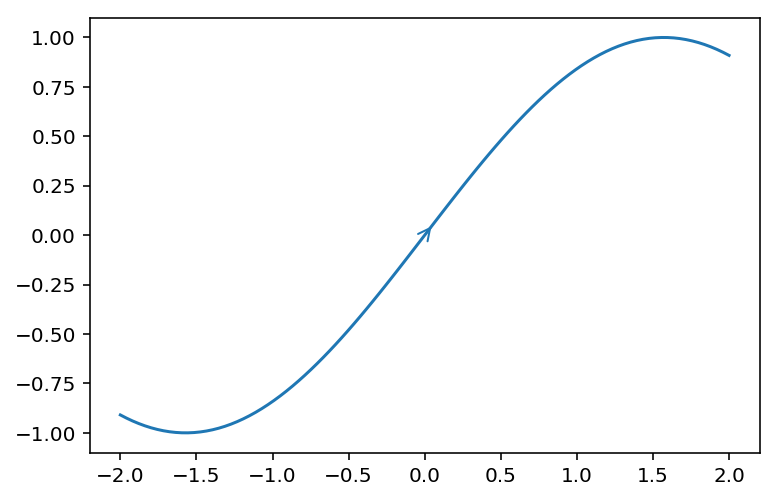

In [10]:
#https://stackoverflow.com/questions/34017866/arrow-on-a-line-plot-with-matplotlib
def add_arrow(line, position=None, direction='right', size=15, color=None):
    """
    add an arrow to a line.

    line:       Line2D object
    position:   x-position of the arrow. If None, mean of xdata is taken
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """
    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if position is None:
        position = xdata.mean()
    # find closest index
    start_ind = np.argmin(np.absolute(xdata - position))
    if direction == 'right':
        end_ind = start_ind + 1
    else:
        end_ind = start_ind - 1

    line.axes.annotate('',
        xytext=(xdata[start_ind], ydata[start_ind]),
        xy=(xdata[end_ind], ydata[end_ind]),
        arrowprops=dict(arrowstyle="->", color=color),
        size=size
    )


t = np.linspace(-2, 2, 100)
y = np.sin(t)
# return the handle of the line
line = plt.plot(t, y)[0]

add_arrow(line)

plt.show()